In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.dates as mdates 
from scipy import stats

%matplotlib inline 


file_path = "./datasets/Building_Energy_Benchmarking.csv"

chunk_size = 100000  # number of rows to read at a time

chunks = []
for chunk in pd.read_csv(file_path, chunksize=chunk_size, encoding="utf8"):
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

In [46]:
data_shape = df.shape

print(f"The provided data has {data_shape[0]} rows and {data_shape[1]} columns")
print("\n")
print("The columns in the provided CSV: ", df.columns.tolist())
print("\n")
print("Data types of the columns:\n", df.dtypes)


The provided data has 494 rows and 31 columns


The columns in the provided CSV:  ['Property Id', 'Property Name', 'Address 1', 'City', 'Postal Code', 'Province', 'Primary Property Type - Self Selected', 'Number of Buildings', 'Year Built', 'Property GFA - Self-Reported (m²)', 'ENERGY STAR Score', 'Site Energy Use (GJ)', 'Weather Normalized Site Energy Use (GJ)', 'Site EUI (GJ/m²)', 'Weather Normalized Site EUI (GJ/m²)', 'Source Energy Use (GJ)', 'Weather Normalized Source Energy Use (GJ)', 'Source EUI (GJ/m²)', 'Weather Normalized Source EUI (GJ/m²)', 'Total GHG Emissions (Metric Tons CO2e)', 'Total GHG Emissions Intensity (kgCO2e/m²)', 'Direct GHG Emissions (Metric Tons CO2e)', 'Direct GHG Emissions Intensity (kgCO2e/m²)', 'Electricity Use - Grid Purchase (kWh)', 'Natural Gas Use (GJ)', 'District Hot Water Use (GJ)', 'Electricity Use – Generated from Onsite Renewable Systems (kWh)', 'Green Power - Onsite and Offsite (kWh)', 'Avoided Emissions - Onsite and Offsite Green Power (Metric 

In [47]:
numerical_columns = [
    'Number of Buildings',
    'Property GFA - Self-Reported (m²)',
    'ENERGY STAR Score',
    'Site Energy Use (GJ)',
    'Weather Normalized Site Energy Use (GJ)',
    'Site EUI (GJ/m²)',
    'Weather Normalized Site EUI (GJ/m²)',
    'Source Energy Use (GJ)',
    'Weather Normalized Source Energy Use (GJ)',
    'Source EUI (GJ/m²)',
    'Weather Normalized Source EUI (GJ/m²)',
    'Total GHG Emissions (Metric Tons CO2e)',
    'Total GHG Emissions Intensity (kgCO2e/m²)',
    'Direct GHG Emissions (Metric Tons CO2e)',
    'Direct GHG Emissions Intensity (kgCO2e/m²)',
    'Electricity Use - Grid Purchase (kWh)',
    'Natural Gas Use (GJ)',
    'District Hot Water Use (GJ)',
    'Electricity Use – Generated from Onsite Renewable Systems (kWh)',
    'Green Power - Onsite and Offsite (kWh)',
    'Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e)'
]

categorical_columns = [
    'Property Id',
    'Property Name',
    'Address 1',
    'City',
    'Postal Code',
    'Province',
    'Primary Property Type - Self Selected',
    'Unique ID',
    'Year Built',
    'Year Ending'
]

In [48]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Columns with missing values: \n")
print(missing_values)

unacceptable_missing_rate = 40
accepatable_missing_rate = 100 - unacceptable_missing_rate

df = df.dropna(axis=1, thresh=int((accepatable_missing_rate / 100) * len(df)))

Columns with missing values: 

ENERGY STAR Score                                                        329
Weather Normalized Source Energy Use (GJ)                                  2
Natural Gas Use (GJ)                                                      10
District Hot Water Use (GJ)                                              479
Electricity Use – Generated from Onsite Renewable Systems (kWh)          450
Green Power - Onsite and Offsite (kWh)                                   198
Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e)    198
dtype: int64


In [51]:
def extract_float_from_text(value):
    pattern = re.compile(r'(?P<Int>[\d,]+)(?:\.(?P<Frac>\d+))?')
    match = pattern.match(str(value))
    
    if match:
        int_part = match.group("Int").replace(",", "")
        frac_part = match.group("Frac")
        
        if frac_part:
            return float(f"{int_part}.{frac_part}")
        else:
            return float(int_part)
            
    return value

def extract_postal_code_from_text(value):
    match = re.search(r"[A-Za-z0-9]{6}", str(value).strip().replace(" ", ""))
    
    if match:
        postal_code = match.group(0)
        return f"{postal_code[:3].upper()} {postal_code[3:].upper()}"

    return value

def clean_address_one(value):
    return re.sub(r"\b(Aberta|Calgary)\b", "", value, flags=re.IGNORECASE).strip()


for col in numerical_columns:
    if col in df.columns:
        print(col)
        df[col] = df[col].apply(extract_float_from_text)

df["Postal Code"] = df["Postal Code"].apply(extract_postal_code_from_text)
df["Address 1"] = df["Address 1"].apply(clean_address_one)

Number of Buildings
Property GFA - Self-Reported (m²)
Site Energy Use (GJ)
Weather Normalized Site Energy Use (GJ)
Site EUI (GJ/m²)
Weather Normalized Site EUI (GJ/m²)
Source Energy Use (GJ)
Weather Normalized Source Energy Use (GJ)
Source EUI (GJ/m²)
Weather Normalized Source EUI (GJ/m²)
Total GHG Emissions (Metric Tons CO2e)
Total GHG Emissions Intensity (kgCO2e/m²)
Direct GHG Emissions (Metric Tons CO2e)
Direct GHG Emissions Intensity (kgCO2e/m²)
Electricity Use - Grid Purchase (kWh)
Natural Gas Use (GJ)
Green Power - Onsite and Offsite (kWh)
Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e)


In [52]:
def impute_missing_values(df, target_column, method='median'):
    """
    Imputes missing values in the target column using either median (for numbers) or mode (for categorical).
    """
    if target_column in df.columns:
        if method == 'median':
            df[target_column] = df[target_column].fillna(df[target_column].median())
        elif method == 'mode':
            mode_value = df[target_column].mode().iloc[0] if not df[target_column].mode().empty else ""
            df[target_column] = df[target_column].fillna(mode_value)
        else:
            raise ValueError("Method should be 'median' or 'mode'")
    
    return df

for i in range(max(len(numerical_columns), len(categorical_columns))):
    if i < len(numerical_columns):
        col = numerical_columns[i]
        impute_missing_values(df, col, 'median')

    if i < len(categorical_columns):
        col = categorical_columns[i]
        impute_missing_values(df, col, 'mode')

In [53]:
numerical_columns = [col for col in numerical_columns if col in df.columns]
summary_stats = df[numerical_columns].describe()

In [54]:
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
        Number of Buildings  Property GFA - Self-Reported (m²)  \
count           494.000000                         494.000000   
mean              1.060729                        4752.556883   
std               0.278281                       10128.320688   
min               1.000000                         113.000000   
25%               1.000000                        1096.650000   
50%               1.000000                        1806.750000   
75%               1.000000                        4257.900000   
max               3.000000                       85941.000000   

       Site Energy Use (GJ)  Weather Normalized Site Energy Use (GJ)  \
count            494.000000                               494.000000   
mean            8265.670040                              8397.193117   
std            19733.748811                             19877.336939   
min              141.000000                               146.000000   
25%             1232.825000      

In [55]:
outlier_threshold = 3

outliers = (df[numerical_columns] - df[numerical_columns].mean()) / df[numerical_columns].std()
outliers_df = outliers[abs(outliers) > outlier_threshold].fillna(0)

mean_median_diff = df[numerical_columns].mean() - df[numerical_columns].median()

In [56]:
print("Outliers Detected (STD Method):")
display(outliers_df)

Outliers Detected (STD Method):


,Number of Buildings,Property GFA - Self-Reported (m²),Site Energy Use (GJ),Weather Normalized Site Energy Use (GJ),Site EUI (GJ/m²),Weather Normalized Site EUI (GJ/m²),Source Energy Use (GJ),Weather Normalized Source Energy Use (GJ),Source EUI (GJ/m²),Weather Normalized Source EUI (GJ/m²),Total GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/m²),Direct GHG Emissions (Metric Tons CO2e),Direct GHG Emissions Intensity (kgCO2e/m²),Electricity Use - Grid Purchase (kWh),Natural Gas Use (GJ),Green Power - Onsite and Offsite (kWh),Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
print("Mean vs. Median Differences for Skewness:")
print(mean_median_diff)

Mean vs. Median Differences for Skewness:
Number of Buildings                                                           0.060729
Property GFA - Self-Reported (m²)                                          2945.806883
Site Energy Use (GJ)                                                       5710.020040
Weather Normalized Site Energy Use (GJ)                                    5824.693117
Site EUI (GJ/m²)                                                              0.484798
Weather Normalized Site EUI (GJ/m²)                                           0.500324
Source Energy Use (GJ)                                                     7351.927733
Weather Normalized Source Energy Use (GJ)                                  7076.638866
Source EUI (GJ/m²)                                                            0.602753
Weather Normalized Source EUI (GJ/m²)                                         0.629717
Total GHG Emissions (Metric Tons CO2e)                                      495.876316
T

In [58]:
property_type_col = 'Primary Property Type - Self Selected'
eui_col = 'Site EUI (GJ/m²)'

avg_eui_by_property_type = df.groupby(property_type_col)[eui_col].mean().reset_index()

print("Average Energy Use Intensity (EUI) by Property Type:")
print(avg_eui_by_property_type)

Average Energy Use Intensity (EUI) by Property Type:
               Primary Property Type - Self Selected  Site EUI (GJ/m²)
0                                Distribution Center          3.286000
1                                       Fire Station          1.208827
2                     Fitness Center/Health Club/Gym          4.385000
3                               Heated Swimming Pool          4.805333
4                                   Ice/Curling Rink          2.182200
5                                       Indoor Arena          1.106000
6                                 Mixed Use Property          0.458000
7                                             Museum          1.584000
8                         Non-Refrigerated Warehouse          0.768000
9                                             Office          1.519636
10                                             Other          0.070000
11                           Other - Public Services          1.526000
12                      

In [59]:
year_col = 'Year Ending'
ghg_col = 'Total GHG Emissions (Metric Tons CO2e)'

df[year_col] = pd.to_numeric(df[year_col], errors='coerce')
total_ghg_by_year = df.groupby(year_col)[ghg_col].sum().reset_index()


print("Total Greenhouse Gas (GHG) Emissions by Year:")
print(total_ghg_by_year)

Total Greenhouse Gas (GHG) Emissions by Year:
   Year Ending  Total GHG Emissions (Metric Tons CO2e)
0         2019                                 75605.4
1         2020                                 66617.2
2         2021                                 68136.9
3         2022                                 72301.0
4         2023                                 75132.0


In [60]:
property_col = 'Property Name'
energy_col = 'Site Energy Use (GJ)'

aggregated_energy_properties = df.groupby(property_col, as_index=False)[energy_col].sum()
top_energy_properties = aggregated_energy_properties.nlargest(5, energy_col)

print("Top 5 Properties with the Highest Total Energy Consumption:")
print(top_energy_properties)

Top 5 Properties with the Highest Total Energy Consumption:
                                        Property Name  Site Energy Use (GJ)
92                            Stoney Transit Facility              726554.8
74                                  Municipal Complex              406124.1
95                      Village Square Leisure Centre              396268.1
89                           Southland Leisure Centre              245215.1
58  Foothills Aquatic Centre and Bauer and Bush Ar...              122386.6


In [61]:
ghg_col = 'Total GHG Emissions (Metric Tons CO2e)'

Q1 = df[ghg_col].quantile(0.25)
Q3 = df[ghg_col].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df[ghg_col] < lower_bound) | (df[ghg_col] > upper_bound)]

print(f"Outliers in {ghg_col} using IQR Method:")
display(outliers_iqr.head())

Outliers in Total GHG Emissions (Metric Tons CO2e) using IQR Method:


,Property Id,Property Name,Address 1,City,Postal Code,Province,Primary Property Type - Self Selected,Number of Buildings,Year Built,Property GFA - Self-Reported (m²),...,Total GHG Emissions (Metric Tons CO2e),Total GHG Emissions Intensity (kgCO2e/m²),Direct GHG Emissions (Metric Tons CO2e),Direct GHG Emissions Intensity (kgCO2e/m²),Electricity Use - Grid Purchase (kWh),Natural Gas Use (GJ),Green Power - Onsite and Offsite (kWh),Avoided Emissions - Onsite and Offsite Green Power (Metric Tons CO2e),Year Ending,Unique ID
16,10170296,Emergency Operations Centre,673 1 ST NE,Calgary,T2E 6R2,Alberta,Office,1.0,2012,5213.0,...,2931.0,562.1,230.0,44.0,4356404.0,4469.0,4356405.0,2025.0,2023,2023-10170296
57,9492075,Foothills Aquatic Centre and Bauer and Bush Ar...,2424 University DR NW,Calgary,T2N 3Y9,Alberta,Ice/Curling Rink,2.0,1963,8558.0,...,2444.0,285.5,898.0,104.9,2493859.0,17477.0,2493859.0,1159.0,2023,2023-9492075
69,21988597,"Manchester Building E - North and South Tower,...",2808 SPILLER RD SE,Calgary,T2G 4H3,Alberta,Office,3.0,1956,6988.0,...,1979.0,283.3,545.0,78.1,2312959.0,10621.0,2312959.0,1075.0,2023,2023-21988597
71,9265818,Max Bell and Ken Bracko Arenas,1001 BARLOW TR SE,Calgary,T2E 6S2,Alberta,Ice/Curling Rink,1.0,1990,12856.0,...,2583.0,200.9,756.0,58.8,2946436.0,14720.0,2946436.0,1370.0,2023,2023-9265818
73,8854298,Municipal Complex,"800 Macleod Trail SE, , AB T2P 2M5",Calgary,T2P 2M5,Alberta,Office,1.0,1982,85941.0,...,9678.0,112.6,60.0,0.7,9618602.0,1166.0,9618604.0,4472.0,2023,2023-8854298


In [62]:
outliers_mask = (df[ghg_col] < lower_bound) | (df[ghg_col] > upper_bound)

property_type_medians = df.groupby(property_type_col)[ghg_col].median()

df.loc[outliers_mask, ghg_col] = df.loc[outliers_mask, property_type_col].map(property_type_medians)

print(f"Outliers in '{ghg_col}' have been replaced with the median value for each property type.")

Outliers in 'Total GHG Emissions (Metric Tons CO2e)' have been replaced with the median value for each property type.


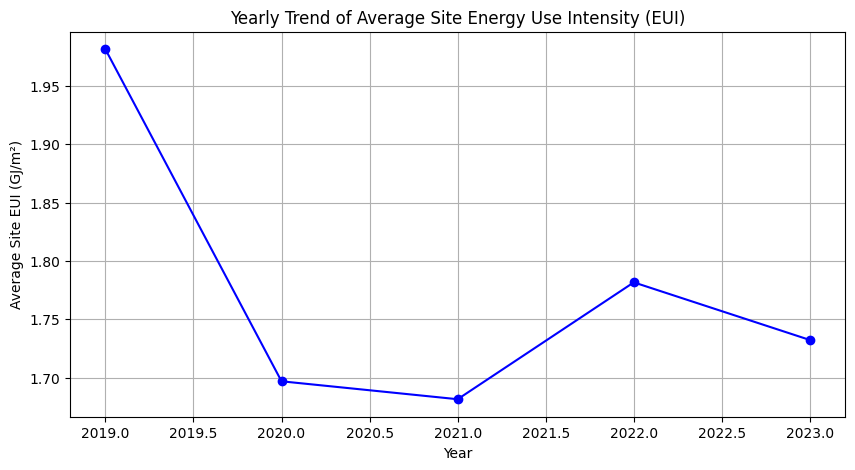

In [63]:
yearly_avg_eui = df.groupby(year_col)[eui_col].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(yearly_avg_eui[year_col], yearly_avg_eui[eui_col], marker='o', linestyle='-', color='b')
plt.xlabel("Year")
plt.ylabel("Average Site EUI (GJ/m²)")
plt.title("Yearly Trend of Average Site Energy Use Intensity (EUI)")
plt.grid(True)
plt.show()

In [64]:
print(f"Outliers in '{ghg_col}' have been replaced with the median value for each property type.")

Outliers in 'Total GHG Emissions (Metric Tons CO2e)' have been replaced with the median value for each property type.


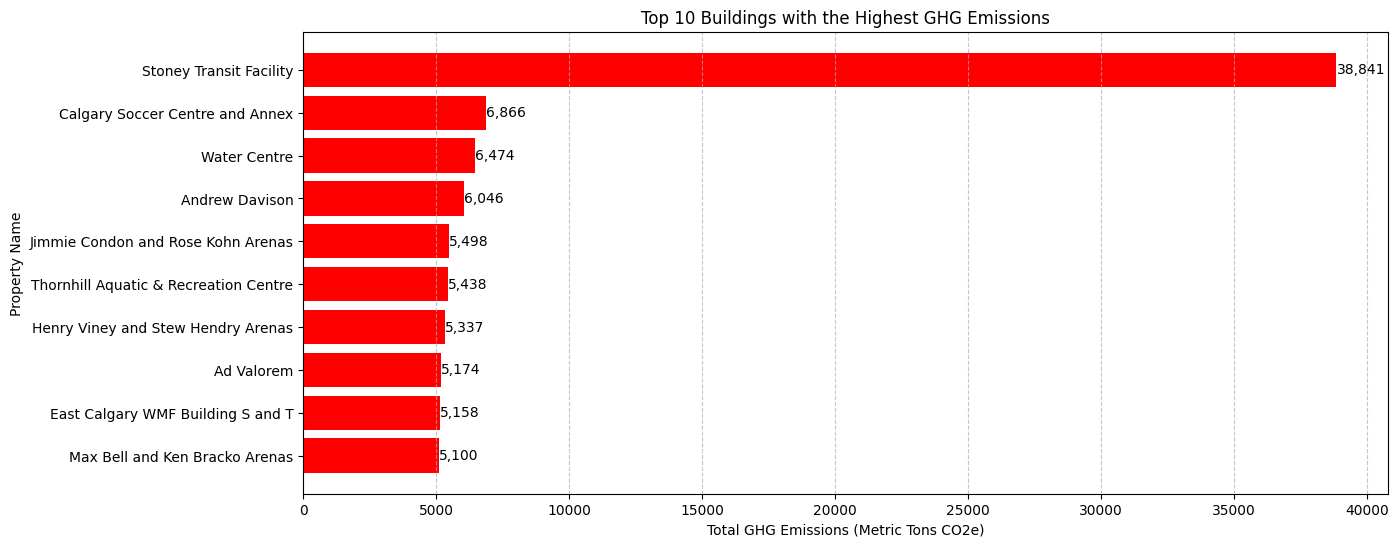

In [65]:
aggregated_ghg_buildings = df.groupby(property_col, as_index=False)[ghg_col].sum()

top_ghg_buildings = aggregated_ghg_buildings.nlargest(10, ghg_col)

plt.figure(figsize=(14, 6))
bars = plt.barh(top_ghg_buildings[property_col], top_ghg_buildings[ghg_col], color='red')

plt.xlabel("Total GHG Emissions (Metric Tons CO2e)")
plt.ylabel("Property Name")
plt.title("Top 10 Buildings with the Highest GHG Emissions")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.yticks(range(len(top_ghg_buildings)), top_ghg_buildings[property_col], fontsize=10)

for bar, value in zip(bars, top_ghg_buildings[ghg_col]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{value:,.0f}',
             va='center', ha='left', fontsize=10, color='black')

plt.show()

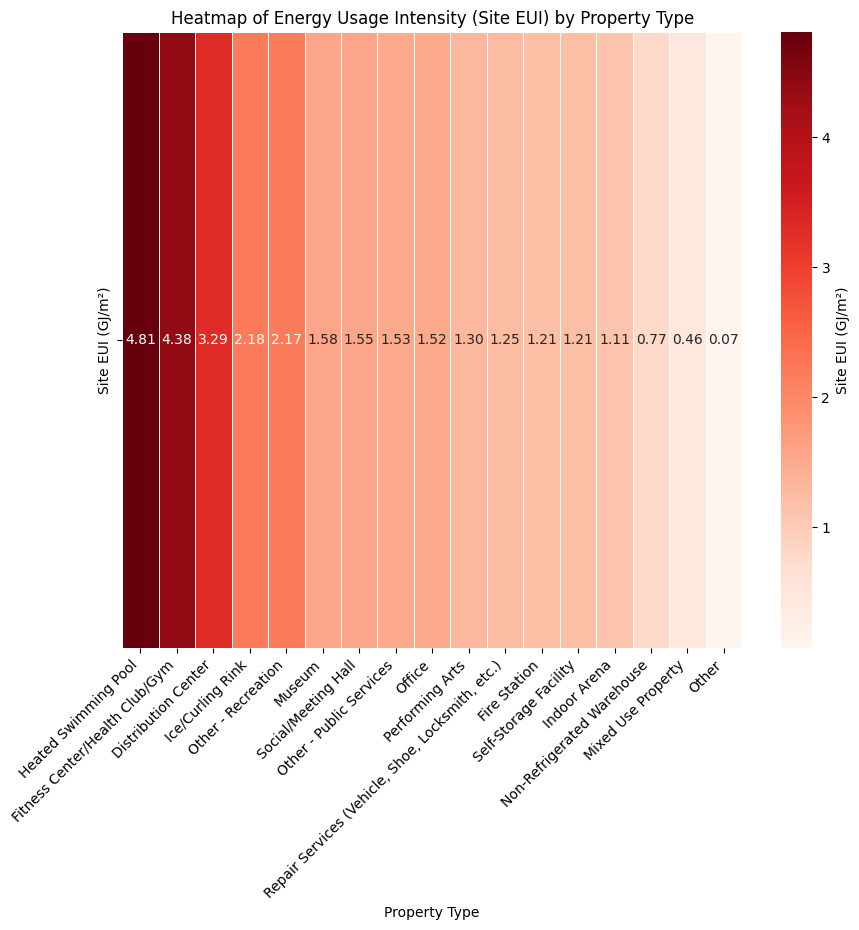

In [66]:
df[eui_col] = pd.to_numeric(df[eui_col], errors='coerce')

eui_by_property_type = df.groupby(property_type_col, as_index=False)[eui_col].mean()
eui_by_property_type = eui_by_property_type.sort_values(by=eui_col, ascending=False)

plt.figure(figsize=(10, 8))
heatmap_data = eui_by_property_type.set_index(property_type_col).T
sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Site EUI (GJ/m²)'})

plt.title("Heatmap of Energy Usage Intensity (Site EUI) by Property Type")
plt.xlabel("Property Type")
plt.xticks(rotation=45, ha="right")
plt.show()

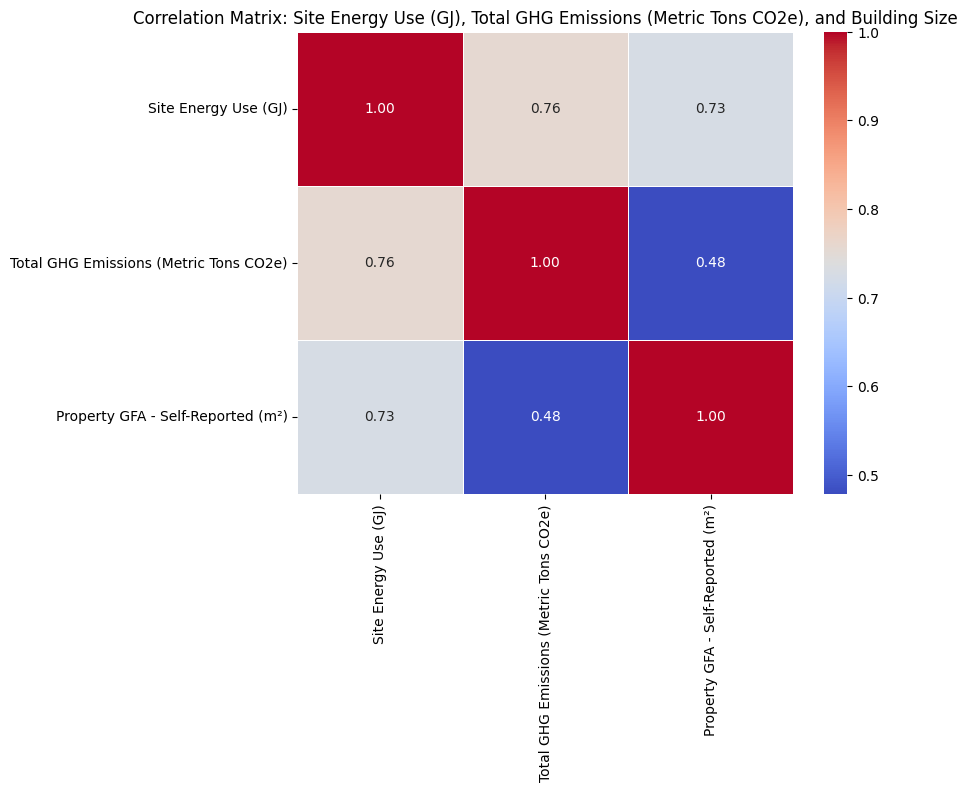


 Correlations 

* Higher energy consumption is strongly associated with higher greenhouse gas (GHG) emissions. 

* Larger buildings tend to produce more GHG emission. 



In [67]:
building_size_col = 'Property GFA - Self-Reported (m²)'

required_cols = [energy_col, ghg_col, building_size_col]
existing_cols = [col for col in required_cols if col in df.columns]

df[existing_cols] = df[existing_cols].apply(pd.to_numeric, errors='coerce')

correlation_matrix = df[existing_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix: Site Energy Use (GJ), Total GHG Emissions (Metric Tons CO2e), and Building Size")
plt.show()


print("\n Correlations \n")
print("* Higher energy consumption is strongly associated with higher greenhouse gas (GHG) emissions. \n")
print("* Larger buildings tend to produce more GHG emission. \n")

In [68]:
property_type_1 = "Office"
property_type_2 = "Fire Station"

group_1 = df[df[property_type_col] == property_type_1][eui_col].dropna()
group_2 = df[df[property_type_col] == property_type_2][eui_col].dropna()

if len(group_1) > 1 and len(group_2) > 1:
    t_stat, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)

    print(f"T-Test Results: {property_type_1} vs {property_type_2}")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_value:.4f} \n")
    
    alpha = 0.05
    if p_value < alpha:
        print(f"Significant difference found (p < {alpha}). The Site EUI (GJ/m²) between '{property_type_1}' and '{property_type_2}' are statistically different.")
    else:
        print(f"No significant difference found (p >= {alpha}). The Site EUI (GJ/m²) between '{property_type_1}' and '{property_type_2}' are not statistically different.")
else:
    print(f"Not enough data points for one or both property types ({property_type_1}: {len(group_1)}, {property_type_2}: {len(group_2)})")

T-Test Results: Office vs Fire Station
t-statistic: 3.0749
p-value: 0.0026 

Significant difference found (p < 0.05). The Site EUI (GJ/m²) between 'Office' and 'Fire Station' are statistically different.
